In [86]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_file
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os
import glob
import pandas as pd
import h5py
import cvlib as cv



In [26]:
class SmallerVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(128, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model


In [3]:
def generate_h5_data(data,labels,filename):
    assert(type(filename) is str)
    assert(len(data) == len(labels)) 
    try:
        filepath= f'./{filename}.h5'


        h5data = h5py.File(filepath, 'w')
        h5data.create_dataset('image',data= data)
        h5data['label'] = labels


    finally:
        h5data.close()

#NO NEED FOR THIS EXERCISE
def load_h5_data(h5filepath):
    h5file = h5py.File(h5filepath, "r")
    try:
        x_fieldname,y_fieldname, = h5file.keys()   #this order is Gfriend files
        print("The keys are: ", h5file.keys())
        data = np.array(h5file['image'][:]) # your test set features
        labels = np.array(h5file['label'][:]) # your test set labels
        print("The shape of x_field",data.shape)
        print("The shape of y_field",labels.shape)
    finally:
        h5file.close()
    return data, labels


In [90]:
def show_20_images(img_array,label_array,offset=0):
    
    assert(len(img_array)==len(label_array))
    
    datalen = len(img_array)
    numOfIter = min(datalen,20)
    
    if numOfIter < 20:
        offset = 0  #if numOfIter < 20, it means it equals datalen, which is less than 20 fed in. So no need offset
        
    numOfRow = numOfIter//4 + (numOfIter%4 != 0)   #a ceiling function
    
    plt.rcParams['figure.figsize'] = (60.0, 100.0) 
    print(img_array.shape)
    num_px = img_array.shape[1] #shape is (m, num_px,num_px,3)
    for i in range(numOfIter):
        plt.subplot(5,4,i+1)  #plot 5 by 4 grid
        #plt.imshow(img_array[i+offset])
        img_preview = img_array[i+offset].reshape(num_px,num_px,3)
        img_preview = np.float32(img_preview)
        img_preview = cv2.cvtColor(img_preview, cv2.COLOR_BGR2RGB)
        plt.imshow(img_preview, interpolation='nearest')  #take only the num_px
        plt.axis('off')
        #print(f'IMG {i+1} is labelled {label_array[i+offset]}')
#         _class = df_unique['breed'][int(label_array[i+offset])]
#         plt.title("Class: " + _class,fontsize = 50)

In [5]:
epochs = 100
lr = 1e-3
batch_size = 64
img_dims = (96,96,3)

In [6]:
df = pd.read_csv("Datasets/labels.csv")
print(df)
df_unique = df.drop_duplicates(subset=['breed'])
df_unique= df_unique.reset_index(drop=True)
print(df_unique)

                                     id                     breed
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo
2      001cdf01b096e06d78e9e5112d419397                  pekinese
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever
...                                 ...                       ...
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever

[10222 rows x 2 columns]
                                   id                 breed
0    000bec180eb18c7604dcecc8fe0dba07           boston_bull
1    001513dfcb2ffafc82cccf4d8bbaba97                 dingo
2 

In [7]:
BreedDict = {}

In [8]:
for ind in df_unique.index: 
     print(df_unique['breed'][ind])
     BreedDict[df_unique['breed'][ind]]=ind

boston_bull
dingo
pekinese
bluetick
golden_retriever
bedlington_terrier
borzoi
basenji
scottish_deerhound
shetland_sheepdog
walker_hound
maltese_dog
norfolk_terrier
african_hunting_dog
wire-haired_fox_terrier
redbone
lakeland_terrier
boxer
doberman
otterhound
standard_schnauzer
irish_water_spaniel
black-and-tan_coonhound
cairn
affenpinscher
labrador_retriever
ibizan_hound
english_setter
weimaraner
giant_schnauzer
groenendael
dhole
toy_poodle
border_terrier
tibetan_terrier
norwegian_elkhound
shih-tzu
irish_terrier
kuvasz
german_shepherd
greater_swiss_mountain_dog
basset
australian_terrier
schipperke
rhodesian_ridgeback
irish_setter
appenzeller
bloodhound
samoyed
miniature_schnauzer
brittany_spaniel
kelpie
papillon
border_collie
entlebucher
collie
malamute
welsh_springer_spaniel
chihuahua
saluki
pug
malinois
komondor
airedale
leonberg
mexican_hairless
bull_mastiff
bernese_mountain_dog
american_staffordshire_terrier
lhasa
cardigan
italian_greyhound
clumber
scotch_terrier
afghan_hound
old_

In [9]:
BreedDict['rottweiler']

119

In [10]:
data = []
labels = []

# Train

In [11]:
image_files_train = [f for f in glob.glob("Datasets/train" + "/**/*", recursive=True) if not os.path.isdir(f)]
random.seed(42)
random.shuffle(image_files_train)
s=os.path.basename(image_files_train[0])
parts = s.split(".")
print(parts[0])
dftrain_lock=df.loc[df['id'] == parts[0]]
print(dftrain_lock['breed'].to_string(index=False).lstrip())
dftrain_lock['breed'].to_string(index=False).lstrip()=="soft-coated_wheaten_terrier"

f6209cf3313e3368c376dbfa13f335cc
soft-coated_wheaten_terrier


True

In [12]:
# create groud-truth label from the image path
for img in image_files_train:
    s=os.path.basename(img)
    parts = s.split(".")
    name=parts[0]
    dftrain_lock=df.loc[df['id'] == parts[0]]
    if dftrain_lock.empty:
        continue
    else:
        image = cv2.imread(img)
        image = cv2.resize(image, (img_dims[0],img_dims[1]))
        image = img_to_array(image)
        data.append(image)
        label = BreedDict[dftrain_lock['breed'].to_string(index=False).lstrip()]
        labels.append([label])




In [13]:
# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [14]:
print('x_data shape:', data.shape)
print('y_data shape:', labels.shape)

x_data shape: (10222, 96, 96, 3)
y_data shape: (10222, 1)


In [15]:
x=labels[20]
print(int(x))

93


(10222, 96, 96, 3)


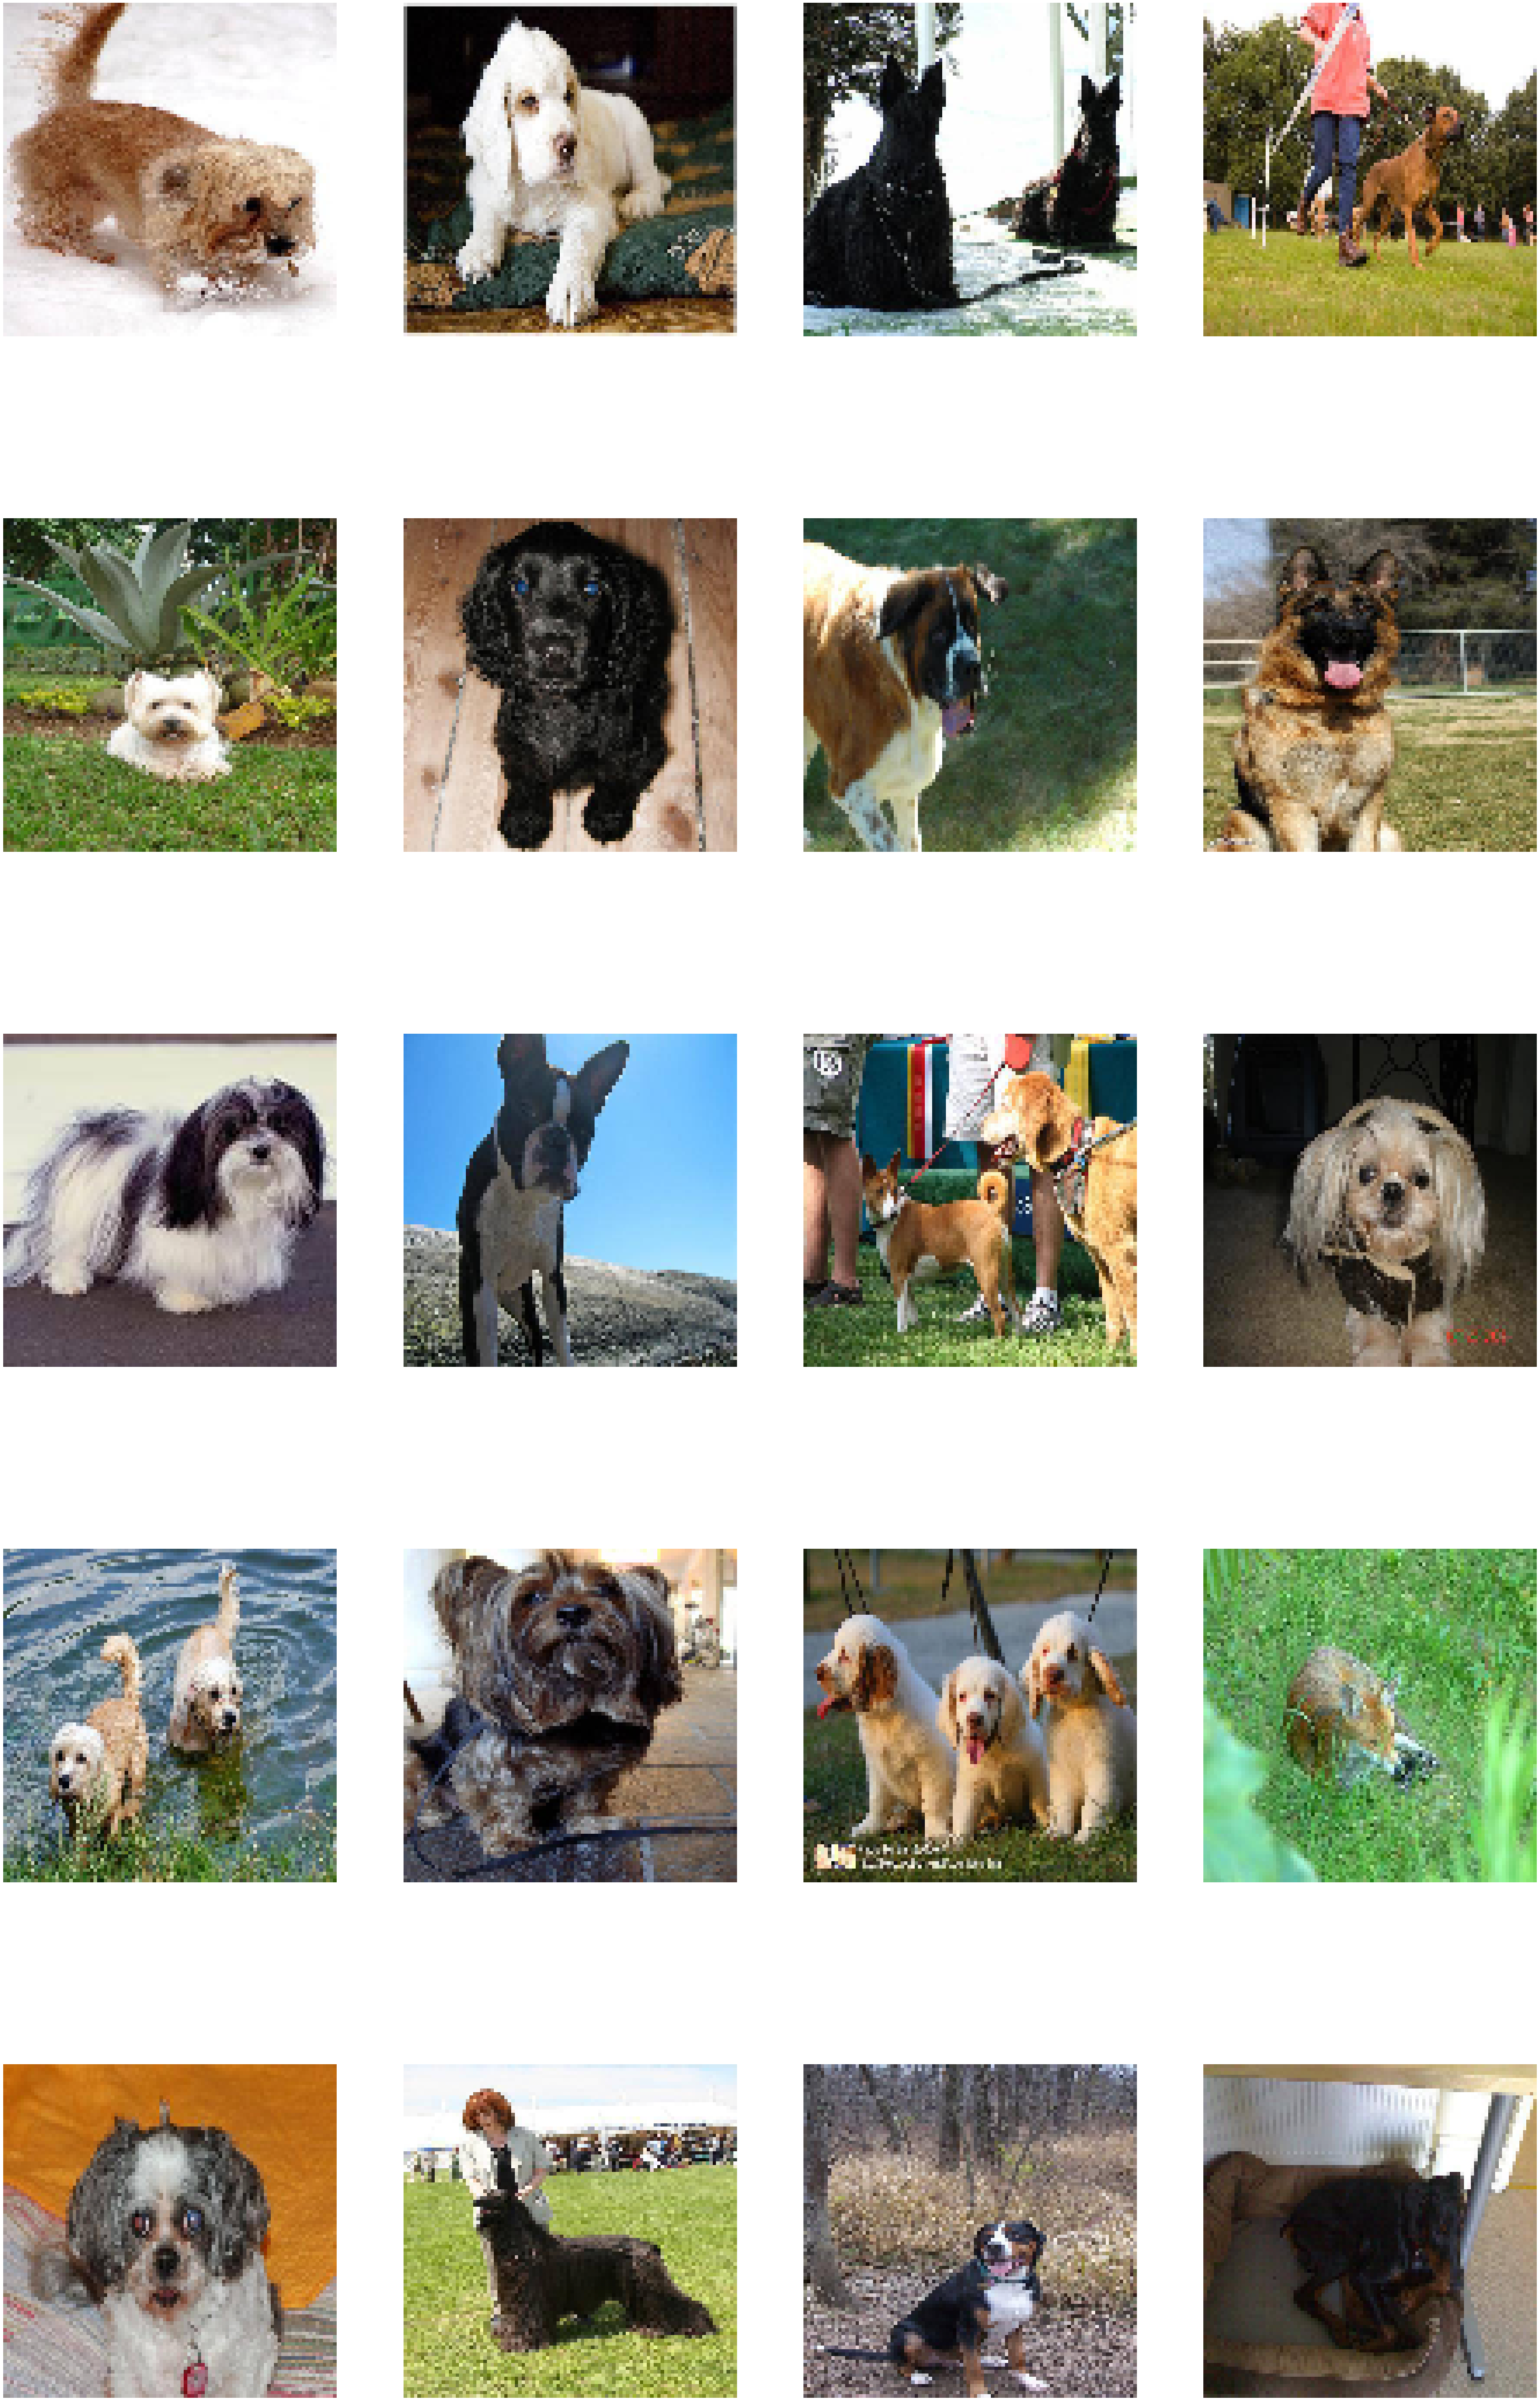

In [91]:
show_20_images(data,labels,20)

In [17]:
with open('trainout.txt', 'w') as f:
    for item in labels:
        f.write("%s\n" % item)

In [18]:
# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)
trainY = to_categorical(trainY, num_classes=120)
testY = to_categorical(testY, num_classes=120)

Epoch 1/100
127/127 [==============================] - 17s 134ms/step - loss: 5.4644 - accuracy: 0.0232 - val_loss: 6.9323 - val_accuracy: 0.0064
Epoch 2/100
127/127 [==============================] - 17s 133ms/step - loss: 5.0651 - accuracy: 0.0330 - val_loss: 6.6466 - val_accuracy: 0.0147
Epoch 3/100
127/127 [==============================] - 17s 135ms/step - loss: 4.8155 - accuracy: 0.0463 - val_loss: 6.3693 - val_accuracy: 0.0215
Epoch 4/100
127/127 [==============================] - 17s 131ms/step - loss: 4.7681 - accuracy: 0.0526 - val_loss: 5.0897 - val_accuracy: 0.0435
Epoch 5/100
127/127 [==============================] - 17s 131ms/step - loss: 4.6364 - accuracy: 0.0627 - val_loss: 4.6049 - val_accuracy: 0.0694
Epoch 6/100
127/127 [==============================] - 17s 132ms/step - loss: 4.4473 - accuracy: 0.0712 - val_loss: 4.9034 - val_accuracy: 0.0689
Epoch 7/100
127/127 [==============================] - 17s 131ms/step - loss: 4.3479 - accuracy: 0.0733 - val_loss: 4.5606 -

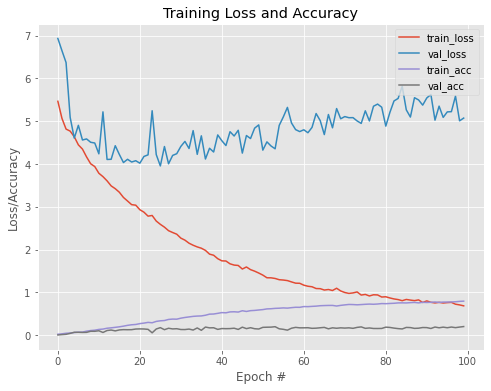

<Figure size 4320x7200 with 0 Axes>

In [27]:
# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

# build model
model = SmallerVGGNet.build(width=img_dims[0], height=img_dims[1], depth=img_dims[2],
                            classes=120)
# compile the model, need to reduce lr to reduce overfit
opt = Adam(lr=lr, decay=lr/epochs)
model.compile(loss="CategoricalCrossentropy", optimizer=opt, metrics=["accuracy"])

# train the model
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, verbose=1)

# save the model to disk
model.save("my_model2")

# plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.show()
# save plot to disk
plt.savefig("my_figures2")
